# Introduction

In this notebook we will be trying to predict gender from images. We will try making our own custom CNN and two variations of transfer learning to do this.  Therefore the goal of this part of the project is to both produce an accurate model and to train quickly and efficiently. We make the model faster by reducing the number of trainable parameters as much as we can. This is done by firstly resizing the images from (200, 200) to (64, 64) which retains almost all of the information but drastically reduces runtime. We will further construct our CNN model to minimize paramters by mapping the fully connected directly from the last convulation to the number of classes. This alieviates problems in a limited computational environment and agrees better with Occams razor framework with the premise that the simplest explanation is probably the best explanation. 

# Reading and Visualizing Data

In [1]:
import os
import tarfile

def removeFile(filename):
  prefix, ext = os.path.splitext(filename)
  newFilename = 'crop_part1_clean.tar.gz'
  original = tarfile.open(filename)
  modified = tarfile.open(newFilename, 'w')
  for info in original.getmembers():
    gender = info.name.replace('crop_part1/', '').split('_')[1]
    if gender != '0' and gender != '1':
      print(info.name)
      continue
    else:
      extracted = original.extractfile(info)
      modified.addfile(info, extracted)
  original.close()
  modified.close()

removeFile('/content/crop_part1.tar.gz')

crop_part1/61_3_20170109150557335.jpg.chip.jpg
crop_part1


In [2]:
from google.colab import drive
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import random 
import os, math
import pandas as pd 
from skimage import io 
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.models as models
from collections import OrderedDict
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import save
from torch import load
import torchtext
import torch
import torchvision
# drive.mount('/content/drive')

In [3]:
import cv2 

class FaceDataset(Dataset):
    """Facial recognition dataset."""

    def __init__(self, root_dir, transform=None):
      self.info =  torchtext.utils.extract_archive(root_dir)
      self.root_dir = root_dir
      self.transform = transform

    def __len__(self):
      return len(self.info)

    def __getitem__(self, idx):
      if torch.is_tensor(idx):
        idx = idx.tolist()

      file = self.info[idx]
      image = io.imread(file)
      image = cv2.resize(image, (64, 64))
      image = transforms.ToTensor()(image)
      # The labels of each face image is embedded in the file name, formated like [age]_[gender]_[race]_[date&time].jpg
      age = file.replace('/content/crop_part1/', '').split('_')[0]
      gender = int(file.replace('/content/crop_part1/', '').split('_')[1])
      ethnicity = file.replace('/content/crop_part1/', '').split('_')[2]
      if gender != 0 and gender != 1:
        print(file)
        print(gender)

      if self.transform:
        image = self.transform(image)
      
      return (image, torch.tensor(gender))

In [41]:
path = '/content/crop_part1_clean.tar.gz'

data_transform = transforms.Compose([
      transforms.RandomHorizontalFlip(p=0.5),
      transforms.RandomVerticalFlip(p=.5),
      transforms.RandomPerspective(distortion_scale=0.2, p=.3, interpolation=torchvision.transforms.InterpolationMode.NEAREST, fill=0),
      transforms.RandomRotation(degrees = 30),
      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

])

data = FaceDataset(path, transform=transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]))
augmented_data = FaceDataset(path, transform=data_transform)
# increase the size of training data with image augmentation
combined_data = torch.utils.data.ConcatDataset([augmented_data, data])

In [6]:
# loader = DataLoader(combined_data, batch_size=len(combined_data), num_workers=2)
# sample = next(iter(loader))
# data_mean, data_std = sample[0].mean(), sample[0].std()

0 torch.Size([3, 64, 64])


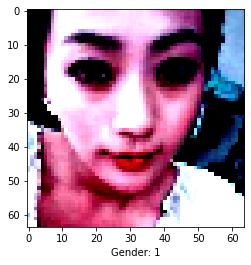

1 torch.Size([3, 64, 64])


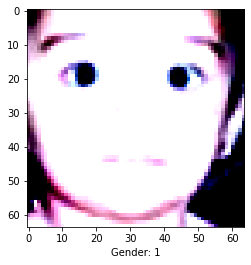

2 torch.Size([3, 64, 64])


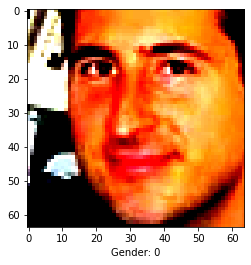

In [42]:
# non augmented images
for i in range(3):
    sample = data[i]

    print(i, sample[0].shape)
    plt.xlabel("Gender: {}".format(sample[1]))
    plt.imshow(sample[0].permute(1, 2, 0).numpy())
    plt.show()

0 torch.Size([3, 64, 64])


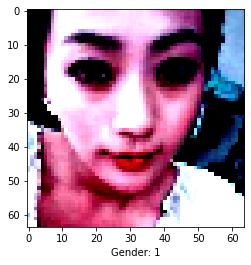

1 torch.Size([3, 64, 64])


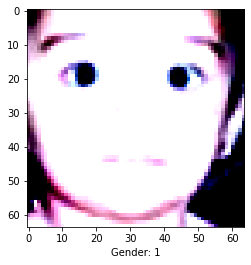

2 torch.Size([3, 64, 64])


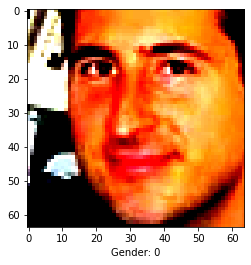

In [43]:
# augmented images
for i in range(3):
  sample = augmented_data[i]

  print(i, sample[0].shape)
  plt.xlabel("Gender: {}".format(sample[1]))
  plt.imshow(sample[0].permute(1, 2, 0).numpy())
  plt.show()

In [44]:
# split data into training/validation/test

# first split train/test with 80/20 split
train, test = torch.utils.data.random_split(combined_data, [15646, 3912])

# then split train into train/valid with a 75/25 split
train, valid = torch.utils.data.random_split(train, [11734, 3912])

# final percentages:
# train: .6, valid: .2, test: .2 

In [45]:
batch_size = 64
train_loader = DataLoader(train, batch_size=batch_size, num_workers=2, shuffle=True)
valid_loader = DataLoader(valid, batch_size=batch_size, num_workers=2, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, num_workers=2, shuffle=True)

# Utility Functions



In [51]:
def init_weights(net):
    """
    Usage: net = Model()
           net.apply(init_weights)
    """
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.ones_(m.weight)
            nn.init.zeros_(m.bias)
        elif isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)

In [52]:
import torchvision.models as models
import torch.optim as optim


def train(args, save=False):
    device = torch.device("cuda")
    model = args.model.to(device)
    model.train()
    optimizer = optim.Adam(params=model.parameters(), lr=args.learning_rate, weight_decay=args.regularization, amsgrad=False)
    # optimizer = optim.SGD(params=model.parameters(), lr=args.learning_rate, weight_decay=args.regularization)
    criterion = torch.nn.CrossEntropyLoss()
    train_loader, valid_loader = args.train, args.valid 
    scheduler = optim.lr_scheduler.StepLR(optimizer, args.step, gamma=0.1, last_epoch=-1, verbose=True)

    if args.init_weight:
      model.apply(init_weights)

    train_loss_hist = []
    valid_loss_hist = []
    train_accuracy_hist = []
    valid_accuracy_hist = []

    for epoch in range(args.epochs):  # loop over the dataset multiple times
      model.train()
      train_loss = 0.0
      valid_loss = 0.0
      train_accuracy = 0.0
      valid_accuracy = 0.0
      total1, total2 = 0, 0

      for i, data in enumerate(train_loader, 1):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        # zero the parameter gradients
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        
        # forward + backward + optimize
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_accuracy += (predicted == labels).float().sum() 
        total1 += inputs.size(0)


      for j, data in enumerate(valid_loader, 1):
        model.eval()
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        valid_loss += (loss.item() * inputs.size(0))
        _, predicted = torch.max(outputs.data, 1)
        valid_accuracy += (predicted == labels).float().sum() 
        total2 += inputs.size(0)
      
      scheduler.step()
      train_loss = train_loss/total1
      valid_loss = valid_loss/total2
      train_accuracy = train_accuracy/total1
      valid_accuracy = valid_accuracy/total2
      
      train_loss_hist.append(train_loss)
      valid_loss_hist.append(valid_loss)
      train_accuracy_hist.append(train_accuracy)
      valid_accuracy_hist.append(valid_accuracy)
      print("Training Loss: {} Valid Loss: {} Training Accuracy: {} Valid Accuracy: {}"
      .format(train_loss, valid_loss, train_accuracy, valid_accuracy))
    
    if save:
      torch.save(model, 'model')

    return (train_loss_hist, valid_loss_hist, train_accuracy_hist, valid_accuracy_hist)

In [64]:
def graph_train_valid(train_data, valid_data, title, num):
  epochs = len(train_data)
  plt.plot(range(epochs), train_data, label="training {}".format(title))
  plt.plot(range(epochs), valid_data, label = 'validation {}'.format(title))
  plt.title('GModel{} {}'.format(num, title))
  plt.xlabel("epochs")
  plt.ylabel(title)
  plt.legend()
  plt.show()

In [54]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import time

def final_score(model, device, test_loader):
  model = model.to(device)
  model.eval()
  preds = []
  true = []
  start =  time.time()

  for i, data in enumerate(test_loader):
    inputs, labels = data 
    inputs = inputs.to(device)
    size = inputs.size(0)
    pred = torch.argmax(model(inputs), dim = 1).tolist()
    pred = map(int, pred)
    preds.extend(list(pred))
    true.extend(labels.tolist())

  precision = precision_score(true, preds)
  recall = recall_score(true, preds)
  f1 = f1_score(true, preds)

  cm = confusion_matrix(true, preds)
  df_cm = pd.DataFrame(cm, range(2), range(2))
  sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
  plt.show()

  end = time.time()

  return precision, recall, f1, (end-start)

# Custom CNN and train 

In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class GenderCNN1(torch.nn.Module):
    def __init__(self):
      super(GenderCNN1, self).__init__() 
      self.dropout = nn.Dropout(.25)
      self.pool = nn.MaxPool2d((2, 2), (2, 2))

      self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, bias=True)
      self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, bias=False)
      self.batch1 = nn.BatchNorm2d(64)
      self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, bias=True)
      self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, bias=False)
      self.batch2 = nn.BatchNorm2d(64)

      self.fc1 = nn.Linear(in_features=6400, out_features=2, bias=False)

    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = self.batch1(self.conv2(x))
      x = F.relu(x)
      x = self.dropout(self.pool(x))

      x = F.relu(self.conv3(x))
      x = self.batch2(self.conv4(x))
      x = F.relu(x)
      x = self.dropout(self.pool(x))

      x = torch.flatten(x, 1)
      x = self.fc1(x)

      return x
      

device = torch.device("cuda")
model = GenderCNN1()
summary(model.to(device), (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 60, 60]           2,432
            Conv2d-2           [-1, 64, 56, 56]          51,200
       BatchNorm2d-3           [-1, 64, 56, 56]             128
         MaxPool2d-4           [-1, 64, 28, 28]               0
           Dropout-5           [-1, 64, 28, 28]               0
            Conv2d-6           [-1, 64, 24, 24]         102,464
            Conv2d-7           [-1, 64, 20, 20]         102,400
       BatchNorm2d-8           [-1, 64, 20, 20]             128
         MaxPool2d-9           [-1, 64, 10, 10]               0
          Dropout-10           [-1, 64, 10, 10]               0
           Linear-11                    [-1, 2]          12,800
Total params: 271,552
Trainable params: 271,552
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/

In [56]:
import torch.optim as optim
class Args(object):
    pass

args1 = Args();
args1.learning_rate = .005
args1.regularization = 5e-4

args1.model = GenderCNN1()
args1.train = train_loader
args1.valid = valid_loader 
args1.epochs = 15
args1.init_weight = True
args1.step = 5
train_loss1, valid_loss1, train_accuracy1, valid_accuracy1, = train(args1)

Adjusting learning rate of group 0 to 5.0000e-03.
Adjusting learning rate of group 0 to 5.0000e-03.
Training Loss: 1.161272327040862 Valid Loss: 0.7517025875411394 Training Accuracy: 0.6271519064903259 Valid Accuracy: 0.5971369743347168
Adjusting learning rate of group 0 to 5.0000e-03.
Training Loss: 0.6154090762747925 Valid Loss: 0.4844906426402445 Training Accuracy: 0.7138230800628662 Valid Accuracy: 0.7643148899078369
Adjusting learning rate of group 0 to 5.0000e-03.
Training Loss: 0.48289968616128964 Valid Loss: 0.5010407805016192 Training Accuracy: 0.767257571220398 Valid Accuracy: 0.7533230781555176
Adjusting learning rate of group 0 to 5.0000e-03.
Training Loss: 0.42910109726781637 Valid Loss: 0.41532535531038156 Training Accuracy: 0.791290283203125 Valid Accuracy: 0.8024028539657593
Adjusting learning rate of group 0 to 5.0000e-04.
Training Loss: 0.40545127211284326 Valid Loss: 0.4050876247127119 Training Accuracy: 0.8070564270019531 Valid Accuracy: 0.7988241314888
Adjusting le

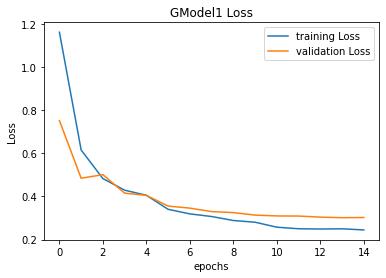

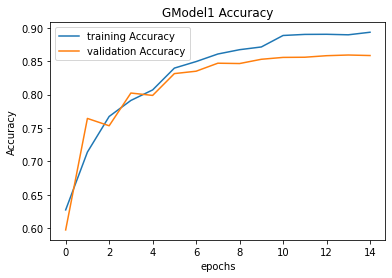

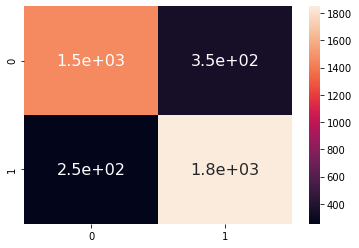

Test Precision: 0.8408367439745339 Test Recall: 0.8792201616737993 Test F1: 0.8596001859600186 Total Time: 4.964694499969482 seconds


In [65]:
graph_train_valid(train_loss1, valid_loss1, 'Loss', 1)

graph_train_valid(train_accuracy1, valid_accuracy1, 'Accuracy', 1)

precision1, recall1, f1_1, time1 = final_score(args1.model, device, test_loader)

print("Test Precision: {} Test Recall: {} Test F1: {} Total Time: {} seconds".format(precision1, recall1, f1_1, time1))

In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class GenderCNN2(torch.nn.Module):
    def __init__(self):
      super(GenderCNN2, self).__init__() 
      self.dropout = nn.Dropout(.25)
      self.pool1 = nn.MaxPool2d((2, 2), (2, 2))
      self.pool2 = nn.MaxPool2d((2, 2))

      self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=5, stride=1, bias=True)
      self.batch1 = nn.BatchNorm2d(96)

      self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, bias=False)
      self.batch2 = nn.BatchNorm2d(256)

      self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, bias=False)
      self.batch3 = nn.BatchNorm2d(384)

      self.conv4 = nn.Conv2d(in_channels=384, out_channels=512, kernel_size=3, stride=1, bias=False)
      self.batch4 = nn.BatchNorm2d(512)

      self.fc1 = nn.Linear(in_features=512, out_features=2, bias=False)

    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = self.dropout(self.pool1(self.batch1(x)))

      x = F.relu(self.conv2(x))
      x = self.dropout(self.pool2(self.batch2(x)))

      x = F.relu(self.conv3(x))
      x = self.dropout(self.pool2(self.batch3(x)))

      x = F.relu(self.conv4(x))
      x = self.dropout(self.pool2(self.batch4(x)))

      x = torch.flatten(x, 1)
      x = self.dropout(self.fc1(x))

      return x
      

device = torch.device("cuda")
model = GenderCNN2()
summary(model.to(device), (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 60, 60]           7,296
       BatchNorm2d-2           [-1, 96, 60, 60]             192
         MaxPool2d-3           [-1, 96, 30, 30]               0
           Dropout-4           [-1, 96, 30, 30]               0
            Conv2d-5          [-1, 256, 26, 26]         614,400
       BatchNorm2d-6          [-1, 256, 26, 26]             512
         MaxPool2d-7          [-1, 256, 13, 13]               0
           Dropout-8          [-1, 256, 13, 13]               0
            Conv2d-9          [-1, 384, 11, 11]         884,736
      BatchNorm2d-10          [-1, 384, 11, 11]             768
        MaxPool2d-11            [-1, 384, 5, 5]               0
          Dropout-12            [-1, 384, 5, 5]               0
           Conv2d-13            [-1, 512, 3, 3]       1,769,472
      BatchNorm2d-14            [-1, 51

In [60]:
import torch.optim as optim
class Args(object):
    pass

args2 = Args();
args2.learning_rate = .001
args2.regularization = 5e-4
args2.log_dir = 'logdir' 

args2.model = GenderCNN2()
args2.train = train_loader
args2.valid = valid_loader 
args2.epochs = 30 
args2.init_weight = True
args2.step = 10
train_loss2, valid_loss2, train_accuracy2, valid_accuracy2, = train(args2)

Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-02.
Training Loss: 0.8769190503747536 Valid Loss: 0.6286484224908435 Training Accuracy: 0.6081472635269165 Valid Accuracy: 0.6538854837417603
Adjusting learning rate of group 0 to 1.0000e-02.
Training Loss: 0.6210661056359907 Valid Loss: 0.5788354191068248 Training Accuracy: 0.6833986639976501 Valid Accuracy: 0.7211145162582397
Adjusting learning rate of group 0 to 1.0000e-02.
Training Loss: 0.5361652689917197 Valid Loss: 0.5295209394642181 Training Accuracy: 0.722686231136322 Valid Accuracy: 0.7080776691436768
Adjusting learning rate of group 0 to 1.0000e-02.
Training Loss: 0.5131418679689902 Valid Loss: 0.49116569775745184 Training Accuracy: 0.731464147567749 Valid Accuracy: 0.7538343667984009
Adjusting learning rate of group 0 to 1.0000e-02.
Training Loss: 0.49181431281987215 Valid Loss: 0.4635833234874749 Training Accuracy: 0.7486791014671326 Valid Accuracy: 0.7684049010276794
Adjusting 

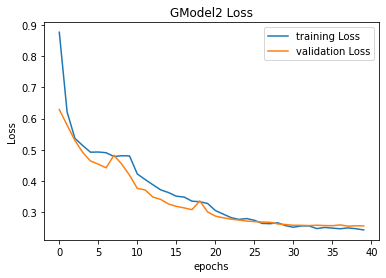

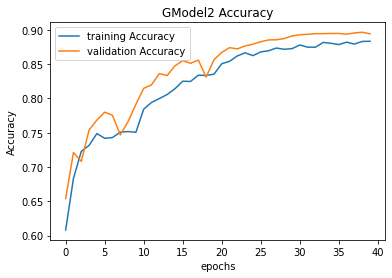

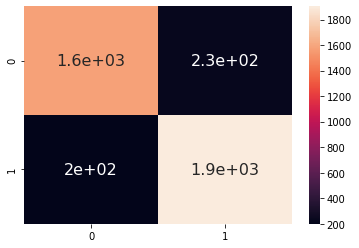

Test Precision: 0.8930581613508443 Test Recall: 0.9053732762719924 Test F1: 0.8991735537190083 Total Time: 5.3494391441345215 seconds


In [66]:
graph_train_valid(train_loss2, valid_loss2, 'Loss', 2)

graph_train_valid(train_accuracy2, valid_accuracy2, 'Accuracy', 2)

precision2, recall2, f1_2, time2 = final_score(args2.model, device, test_loader)

print("Test Precision: {} Test Recall: {} Test F1: {} Total Time: {} seconds".format(precision2, recall2, f1_2, time2))

# Transfer Learning V1

  * replace last layer 
  * add dropout
  * high regularization
  * Train pretrained model for 10 epochs with all gradients
  * freeze everything that isn't the last layer
  * fine tune the last layer

In [76]:
class Args(object):
    pass

args3 = Args();
args3.learning_rate = 0.001
args3.regularization = .001

args3.train = train_loader
args3.valid = valid_loader 
args3.epochs = 20
args3.init_weight = False
args3.step = 10

In [77]:
# model = models.googlenet(pretrained=True)
model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet50', pretrained=True)
for param in model.parameters():
    param.requires_grad = False

# add dropout to prevent overfitting 
model.fc = nn.Sequential(
     nn.Dropout(.25),
     nn.Linear(model.fc.in_features, 2)
)

# only fine tune last layer 
for param in model.parameters():
  if i == 160:
    param.requires_grad = True
  else:
    param.requires_grad = False
  i += 1

args3.model = model
train_loss3, valid_loss3, train_accuracy3, valid_accuracy3, = train(args3)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Training Loss: 0.4341046998859244 Valid Loss: 0.469971555020424 Training Accuracy: 0.7940174341201782 Valid Accuracy: 0.7413087487220764
Adjusting learning rate of group 0 to 1.0000e-03.
Training Loss: 0.3851647128263567 Valid Loss: 0.4231233505383591 Training Accuracy: 0.8187319040298462 Valid Accuracy: 0.7960122227668762
Adjusting learning rate of group 0 to 1.0000e-03.
Training Loss: 0.39789204708615944 Valid Loss: 0.4308622757350009 Training Accuracy: 0.8018578886985779 Valid Accuracy: 0.782975435256958
Adjusting learning rate of group 0 to 1.0000e-03.
Training Loss: 0.39054293076894914 Valid Loss: 0.6611298761484813 Training Accuracy: 0.8085052371025085 Valid Accuracy: 0.7206032276153564
Adjusting learning rate of group 0 to 1.0000e-03.
Training Loss: 0.38060448929929075 Valid Loss: 0.40484707633410494 Training Accuracy: 0.816516101360321 Valid Accuracy: 0.7988241314888
Adjusting le

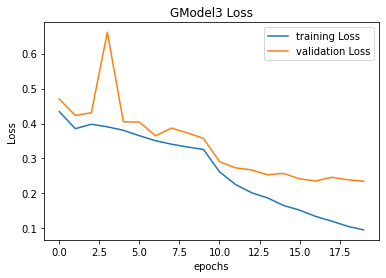

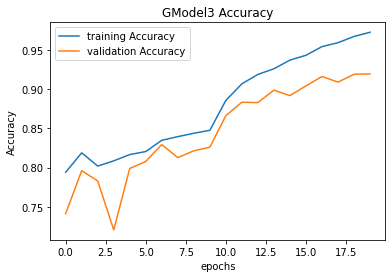

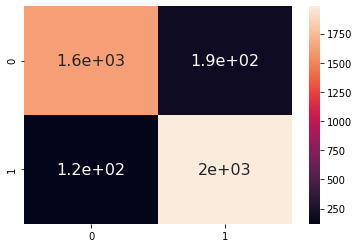

Test Precision: 0.9121435142594296 Test Recall: 0.9429386590584878 Test F1: 0.9272854804769699 Total Time: 5.798952102661133 seconds


In [78]:
graph_train_valid(train_loss3, valid_loss3, 'Loss', 3)

graph_train_valid(train_accuracy3, valid_accuracy3, 'Accuracy', 3)

precision3, recall3, f1_3, time3 = final_score(args3.model, device, test_loader)

print("Test Precision: {} Test Recall: {} Test F1: {} Total Time: {} seconds".format(precision3, recall3, f1_3, time3))

# Transfer Learning V2

  * Use pretrained-CNN as a feature extractor
  * Take output as last layer as input to new model
  * Convert everything to Apache Spark so that we can actually compute it in reasonable time
  * Use train/validation for hyperparameter tuning for Random Forest
  * Measure final model accuracy for Random Forest using test data


In [79]:
class Args(object):
    pass
device = torch.device('cuda')
args4 = Args()
model = models.googlenet(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

args4.model = model
# summary(model.to(device), (3, 64, 64))

In [80]:
def transfer(model, device, batch_size, num_features, loader):
  model = model.to(device)
  model.eval()
  x = pd.DataFrame(0, index=range(len(loader) * batch_size), columns=range(num_features))
  y = pd.DataFrame(0, index=range(len(loader) * batch_size), columns=range(1))

  for i, data in enumerate(loader, 0):
      inputs, labels = data
      inputs = inputs.to(device)
      size = inputs.size(0)
      labels = labels.to(device).cpu().detach().numpy().reshape(size, 1)
      outputs = model(inputs).cpu().detach().numpy()
      x[i * size: (i+1) * size]  = outputs
      y[i * size: (i+1) * size]  = labels

  return (x, y)

In [94]:
num_features = 1000
x_train, y_train = transfer(args4.model, device, 64, num_features, train_loader)
x_valid, y_valid = transfer(args4.model, device, 64, num_features, valid_loader)
x_test, y_test = transfer(args4.model, device, 64, num_features, test_loader)
train = pd.concat([x_train, y_train], axis=1)
valid = pd.concat([x_valid, y_valid], axis=1)
test = pd.concat([x_test, y_test], axis=1)

In [ ]:
cols = ['feature'+str(i) for i in range(1000)]
cols.append('gender')

train.set_axis(cols, axis=1, inplace=True)
valid.set_axis(cols, axis=1, inplace=True)
test.set_axis(cols, axis=1, inplace=True)

In [ ]:
train.to_csv('train')
valid.to_csv('valid')
test.to_csv('test')

In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql import SparkSession
import pyspark
import pandas as pd

spark = SparkSession.builder.appName('random forest').getOrCreate()

train_sdf = spark.read.csv('train', inferSchema=True, header=True)
test_sdf = spark.read.csv('test', inferSchema=True, header=True)

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer

cols = train_sdf.columns

assembler = VectorAssembler(inputCols=cols[:-1], outputCol='features')
train_sdf = assembler.transform(train_sdf)


In [ ]:
cols = test_sdf.columns

assembler = VectorAssembler(inputCols=cols[:-1], outputCol='features')
test_sdf = assembler.transform(test_sdf)


In [ ]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="gender", featuresCol="features")
rf = rf.fit(train_sdf)

In [ ]:
train_predictions = rf.transform(train_sdf)
start = time.time()
test_predictions = rf.transform(test_sdf)
time4 = time.time() - start

In [ ]:
from pyspark.sql.functions import col

list1 = train_predictions.select(col("prediction")).collect()
train_pred = [int(row.prediction) for row in list1]

list2 = test_predictions.select(col("prediction")).collect()
test_pred = [int(row.prediction) for row in list2]

list3 = train_predictions.select(col("gender")).collect()
train_label = [int(row.gender) for row in list3]

list4 = test_predictions.select(col("gender")).collect()
test_label = [int(row.gender) for row in list4]

In [ ]:
precision_train = precision_score(train_pred, train_label)
recall_train = recall_score(train_pred, train_label)
f1_train = f1_score(train_pred, train_label)

precision_test = precision_score(test_pred, test_label)
recall_test = recall_score(test_pred, test_label)
f1_test = f1_score(test_pred, test_label)

print("Train Precision: {} Train Recall: {} Train F1: {} ".format(precision_train, recall_train, f1_train))
print("TestPrecision: {} Test Recall: {} Test F1: {} Time: {}".format(precision_test, recall_test, f1_test, time4))

#Comparing Models

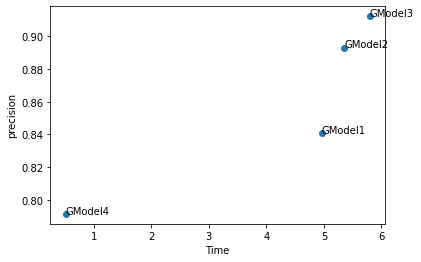

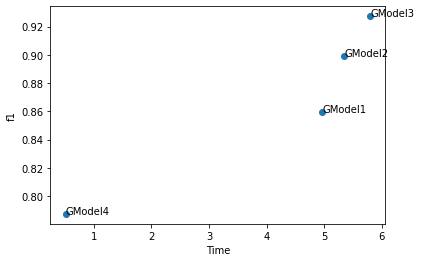

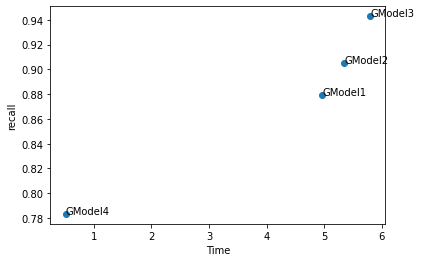

In [95]:
def graph_performance_vs_time(performance, time, names, title):
  plt.scatter(x=time, y=performance)
  for i, label in enumerate(names):
    plt.annotate(label, (time[i], performance[i]))
  plt.xlabel('Time')
  plt.ylabel(title)
  plt.show()

tot_precision = [precision1, precision2, precision3, precision_test]
tot_f1 = [f1_1, f1_2, f1_3, f1_test]
tot_recall = [recall1, recall2, recall3, recall_test]
tot_time = [time1, time2, time3, time4]
names = ['GModel1', 'GModel2', 'GModel3', 'GModel4']

graph_performance_vs_time(tot_precision, tot_time, names, 'precision')
graph_performance_vs_time(tot_f1, tot_time, names, 'f1')
graph_performance_vs_time(tot_recall, tot_time, names, 'recall')